# Bevezetés
Ebben a fájlban fogom az adatokat elemezni, a dataframe oszlopait egyesével átnézni, hogy milyen adatokkal is dolgozom
A feladat írása során a ChatGPT-t használtam a debuggolás segítésében.

In [2]:
# !pip install matplotlib
# !pip install langdetect
# !pip install iso-639

In [3]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from iso639 import languages
from langdetect import detect
import re

In [4]:
df = pd.read_csv('data/TMDB_tv_dataset_v3.csv')

A következő függvényt azoknak az oszlopoknak a feldolgozására készítettem, melyekben több adat is volt vesszővel vagy &-sel elválasztva. Ebben a függvényben az elválasztók mellett szétválasztom az adatokat és egyesével megszámolom az előfordulásukat

In [96]:
def unique_vals(df, col):
    df = df[df[col].apply(lambda x: isinstance(x, str))].copy()
    
    df['col_split'] = df[col].apply(lambda x: [s.strip() for s in re.split(',|&', x)])
    
    unique_values = set(x for sublist in df['col_split'] for x in sublist)

    unique_values= list(unique_values)
    
    count_df={}
    
    for index, row in df.iterrows():
        for item in row['col_split']:
            if item not in count_df:
                count_df[item] = 0
            count_df[item] += 1

    sorted_count = dict(sorted(count_df.items(), key=lambda item: item[1], reverse=True))

    i=0
    
    for key, value in sorted_count.items():
        print(f'{key}: {value}')
        i+=1
        if (i==10):
            break
    
    return 0

# EDA

In [6]:
df.isna().sum()

id                           0
name                         5
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 73323
adult                        0
backdrop_path            88798
first_air_date           31347
last_air_date            29498
homepage                115110
in_production                0
original_name                5
popularity                   0
poster_path              58786
type                         0
status                       0
tagline                 160262
genres                   67208
created_by              129558
languages                57051
networks                 69048
origin_country           31023
spoken_languages         57798
production_companies    107039
production_countries     89170
episode_run_time             0
dtype: int64

## id

## name

Volt 5 darab adatom amely névvel nem rendelkezett. Mivel az adatbázis nagy, így ezeket az oszlopokat rögtön töröltem

In [7]:
df=df.dropna(subset='name')

In [8]:
df.isna().sum()

id                           0
name                         0
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 73318
adult                        0
backdrop_path            88793
first_air_date           31345
last_air_date            29497
homepage                115105
in_production                0
original_name                0
popularity                   0
poster_path              58781
type                         0
status                       0
tagline                 160257
genres                   67203
created_by              129553
languages                57046
networks                 69043
origin_country           31018
spoken_languages         57793
production_companies    107034
production_countries     89165
episode_run_time             0
dtype: int64

## number_of_seasons

Az évadok számosságánál megfigyelhetjük hogy a sorozatok túlnyomó része nem éri el az 50 évadot. Nem igazán meglepő adat, hiszen egy évad általában legalább évnyi filmes munkát jelent, és kevés 50 évnél idősebb sorozat létezik (de persze hogy a kivétel erősítse a szabályt, ott van a Doctor Who)

<Axes: >

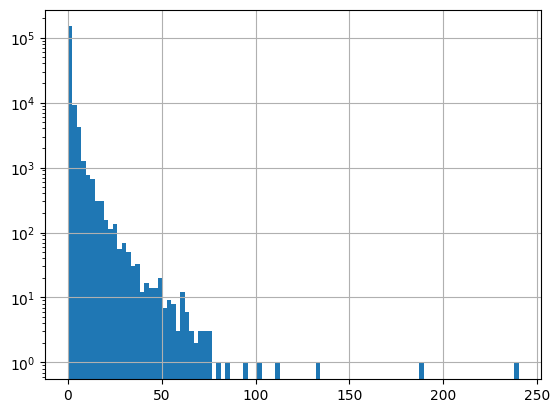

In [111]:
df['number_of_seasons'].hist(bins=100, log=True)

## number_of_episodes

Az epizód számoknál is megfigyelhetjük, hogy a sorozatok többsége kevesebb mint 5000 résszel rendelkezik.

<Axes: >

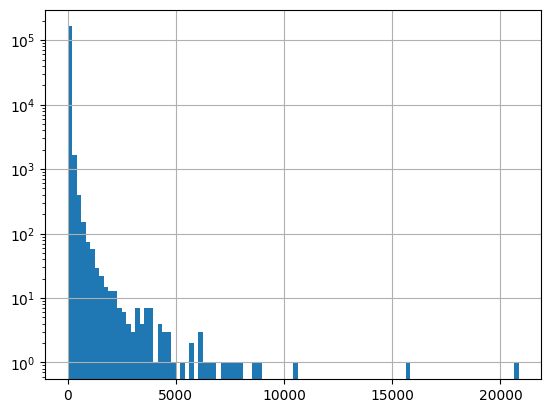

In [112]:
df['number_of_episodes'].hist(bins=100, log=True)

Ha már ismerjük mind az évadok és az epizódok számát, érdekes adat például hogy átlagosan hány rész található egy évadban

In [113]:
df['number_of_episodes'].sum()/df['number_of_seasons'].sum()

15.919771976964386

## original_language

Az original_language-nél kipróbáltam  a *iso639* könyvtárban található dictionary-t hogy meg tudjam hogy a nyelvek jelölései mit jelentenek. Ezek után megnéztem hogy az egyes nyelvek milyen gyakorisággal léteznek

In [10]:
def get_language_name(language_code):
    try:
        return languages.get(part1=language_code).name
    except (KeyError, AttributeError):
        return "Unknown"  # Vagy tetszőleges érték, amit szeretnél az ismeretlen nyelv esetén

In [11]:
df['OG_language'] = df['original_language'].apply(lambda x: get_language_name(x))

In [12]:
len(df[df['OG_language']=='Unknown'])

1922

In [13]:
df=df.drop('original_language', axis=1)

Bár, az angol a legismertebb nyelv, mégis meglepő, hogy mennyire vezet ebben az adatbázisban, ahhoz képest, hogy a földön nem az angol a legtöbbek által használt nyelv, mint anyanyelv. Megértem az előnyét, de a mértéke igazán meglepő számomra, de ez talán abból is fakadhat, hogy az adatbázis angol nyelvterületről eredendő

In [28]:
df['OG_language'].value_counts()

OG_language
English                    75644
Japanese                   13850
Chinese                    13545
Korean                      7725
German                      7454
                           ...  
Swahili (macrolanguage)        1
Southern Sotho                 1
Northern Sami                  1
Mongolian                      1
Afar                           1
Name: count, Length: 103, dtype: int64

## vote_count

A vote_countnál igazából az egyetlen meglepő tény számomra az volt, hogy sokkal több olyan filmre számítottam, ahol szavazatok száma meghaladja a 10000-et.

<Axes: >

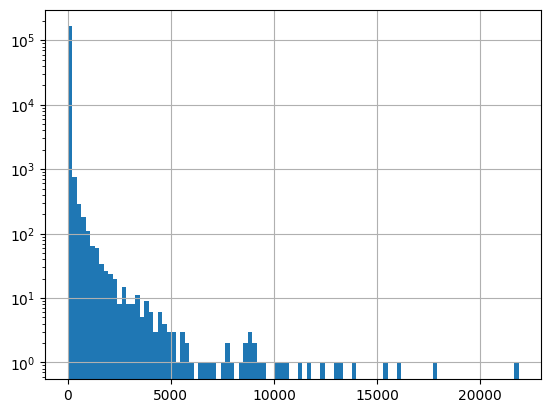

In [39]:
df['vote_count'].hist(bins=100, log=True)

In [42]:
df['vote_count'].mean()

13.550560236779319

In [41]:
df_2=df[df['OG_language']=='English']

In [44]:
df_2['vote_count'].mean()

20.39664745386283

## vote_average

A vote_average-nél igyekeztem megnézni hogy melyik nyelvű filmek kapták a legjobb értékeléseket. Persze, néhány nyelvet ki kellett zárnom, hiszen kevés adattal rendelkeztek és végül alább található a top 10 nyelv

In [45]:
vote_mean= []

cols= df['OG_language'].unique()

In [49]:
cols

array(['English', 'Spanish', 'Korean', 'Japanese', 'German', 'French',
       'Turkish', 'Portuguese', 'Danish', 'Catalan', 'Swedish',
       'Norwegian', 'Thai', 'Italian', 'Chinese', 'Arabic', 'Russian',
       'Icelandic', 'Tagalog', 'Hebrew', 'Polish', 'Dutch', 'Hindi',
       'Finnish', 'Luxembourgish', 'Welsh', 'Galician', 'Ukrainian',
       'Hungarian', 'Czech', 'Latin', 'Romanian', 'Bulgarian', 'Unknown',
       'Modern Greek (1453-)', 'Vietnamese', 'Tamil', 'Serbian',
       'Croatian', 'Persian', 'Zulu', 'Bengali', 'Indonesian',
       'Malay (macrolanguage)', 'Slovak', 'Urdu', 'Telugu', 'Afrikaans',
       'Kannada', 'Sinhala', 'Malayalam', 'Bosnian', 'Irish', 'Estonian',
       'Abkhazian', 'Amharic', 'Albanian', 'Georgian', 'Norwegian Bokmål',
       'Azerbaijani', 'Kurdish', 'Latvian', 'Lithuanian', 'Basque',
       'Marathi', 'Slovenian', 'Herero', 'Central Khmer', 'Maori',
       'Nepali (macrolanguage)', 'Kazakh', 'Assamese', 'Mongolian',
       'Belarusian', 'Norther

In [68]:
avg_dict={}

for lang in cols:
    df_temp=(df[df['OG_language']==lang])
    average=df_temp['vote_average'].mean()
    if df_temp['vote_count'].sum()>1000:
        avg_dict[lang]=average

top_10 = sorted(avg_dict, key=avg_dict.get, reverse=True)[:10]

In [69]:
for key in top_10:
    value = avg_dict[key]
    print(f"{key}: {value}")

Turkish: 3.9487997691863823
Japanese: 3.742375451263538
Modern Greek (1453-): 3.373954292084727
Italian: 3.216095950155763
Hindi: 3.1975522682445763
Spanish: 3.101206684733514
Russian: 3.0732121426050125
Swedish: 2.850844055944056
Thai: 2.631389689578714
Danish: 2.562896012115093


Őszintén meglepett a nyelvek listája, hiszen az Angol nem is szerepel rajta. Remélem ebben valahogyan majd összefüggésre lelek

## overview

Az overview tartalma nem fog érdekelni minket, maximum, hogy volt-e.

In [70]:
df['has_overview']=df['overview'].apply(lambda x: 0 if pd.isna(x) else 1)

In [71]:
df['has_overview'].value_counts()

has_overview
1    92237
0    73318
Name: count, dtype: int64

## adult

Az, hogy a film felnőtttartalmú-e azt szintén egy flag-gé alakítottam

In [16]:
df['adult'] = df['adult'].astype(int)

In [72]:
df['adult'].value_counts()

adult
False    163543
True       2012
Name: count, dtype: int64

## backdrop_path

In [17]:
df['backdrop_path']

0          /2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg
1         /gFZriCkpJYsApPZEF3jhxL4yLzG.jpg
2         /2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg
3         /x4salpjB11umlUOltfNvSSrjSXm.jpg
4         /aDBRtunw49UF4XmqfyNuD9nlYIu.jpg
                        ...               
165555                                 NaN
165556                                 NaN
165557                                 NaN
165558                                 NaN
165559                                 NaN
Name: backdrop_path, Length: 165555, dtype: object

In [18]:
df=df.drop('backdrop_path', axis=1)

## first_air_date

In [19]:
df['first_air_date'] = pd.to_datetime(df['first_air_date'], errors='coerce')

In [20]:
df['first_air_date'].min()

Timestamp('1917-01-09 00:00:00')

Ahol nan értékkel szembesültem, ott az első máig megmaradt film keletkezésének dátumát adtam meg, ezért figyelhetjük meg azt a megugrást az alább hisztogramban. Emellett érdekes megfigyelni, hogy milyen exponenciális eloszlást követnek a dátumok számossága

In [21]:
def_date = pd.to_datetime('1888-10-14')

df['first_air_date'].fillna(def_date, inplace=True)

<Axes: >

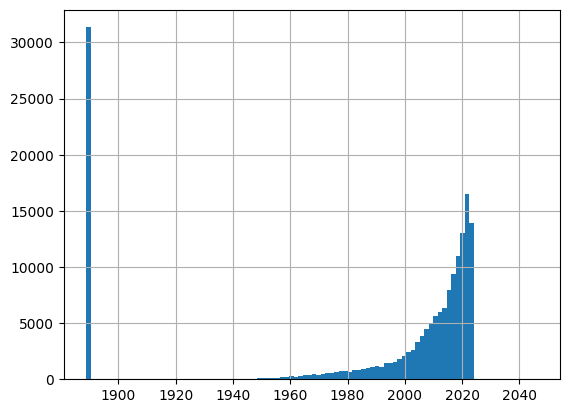

In [22]:
df['first_air_date'].hist(bins=100)

## last_air_date

Itt ugyanaz figyelhető meg mint a first_air_date-nél

In [23]:
df['last_air_date'] = pd.to_datetime(df['last_air_date'], errors='coerce')

In [24]:
df['last_air_date'].min()

Timestamp('1917-01-09 00:00:00')

In [25]:
def_date = pd.to_datetime('1888-10-14')

df['last_air_date'].fillna(def_date, inplace=True)

<Axes: >

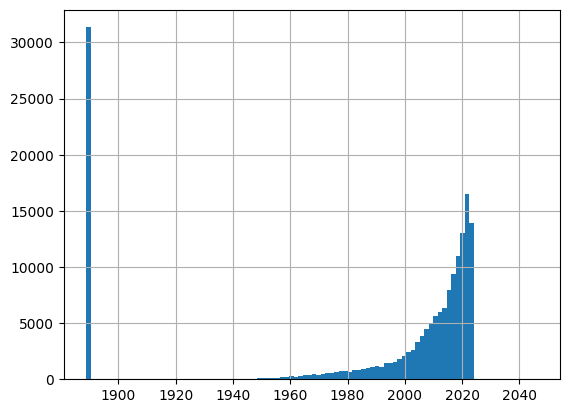

In [26]:
df['first_air_date'].hist(bins=100)

## homepage

In [74]:
df['has_homepage'] = df['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)

In [75]:
df=df.drop('homepage', axis=1)

In [76]:
df['has_homepage'].value_counts()

has_homepage
0    115105
1     50450
Name: count, dtype: int64

## in_production

Ennél az oszlopnál teljesen meglepett az két érték aránya, mivel a filmek számának exponenciális növekedése mellett se számítottam rá, hogy ennyi sorozat igazából még befejezetlen, így fél információkkal dolgozunk esetükben

In [29]:
df['in_production'] = df['in_production'].astype(int)

In [77]:
df['in_production'].value_counts()

in_production
False    97067
True     68488
Name: count, dtype: int64

## original_name

## popularity

In [115]:
df['popularity'].isna().sum()

0

<Axes: >

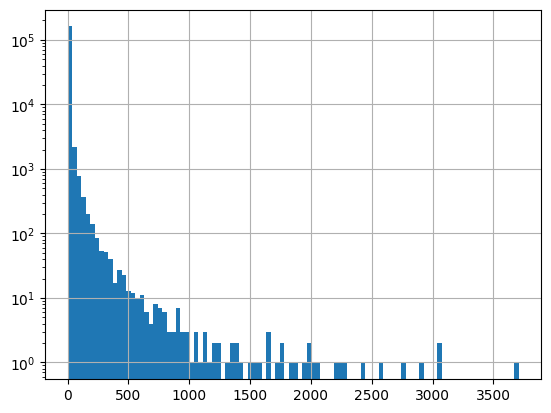

In [30]:
df['popularity'].hist(bins=100, log=True)

## poster_path

In [31]:
df=df.drop('poster_path', axis=1)

## type

In [32]:
df['type'].value_counts()

type
Scripted       127041
Documentary     13452
Miniseries      10639
Reality          9511
Talk Show        2947
Video            1361
News              604
Name: count, dtype: int64

## status

In [35]:
df['status'].value_counts()

status
Ended               92506
Returning Series    65432
Canceled             4561
In Production        2229
Planned               595
Pilot                 232
Name: count, dtype: int64

In [116]:
df_2=df[df['in_production']==True]

In [118]:
df_2['status'].value_counts()

status
Returning Series    65432
In Production        2229
Planned               595
Pilot                 232
Name: count, dtype: int64

In [119]:
df_2=df[df['in_production']==False]

In [120]:
df_2['status'].value_counts()

status
Ended       92506
Canceled     4561
Name: count, dtype: int64

## tagline

In [37]:
df=df.drop('tagline', axis=1)

## genres

A genres-nél az egyedi függvénnyel megvizsgáltam, hogy melyik kategóriák a legnépszerűbbek

In [38]:
print(df['genres'].value_counts())

genres
Documentary                                                                    17274
Drama                                                                          15953
Comedy                                                                         10200
Reality                                                                         7857
Animation                                                                       3296
                                                                               ...  
Animation, Action & Adventure, Drama, Comedy                                       1
Sci-Fi & Fantasy, Comedy, Reality, Action & Adventure                              1
Drama, Animation, Comedy, Action & Adventure                                       1
Animation, Action & Adventure, Comedy, Action & Adventure, Sci-Fi & Fantasy        1
Comedy, Documentary, Sci-Fi & Fantasy, Mystery                                     1
Name: count, Length: 2218, dtype: int64


In [97]:
unique_vals(df, 'genres')


Drama: 33209
Comedy: 23029
Documentary: 21663
Animation: 11873
Reality: 10831
Action: 7202
Adventure: 7202
Crime: 6791
Family: 6432
Sci-Fi: 6316


0

A továbbiakban a legtöbb helyen ezt az egyedi függvényt használtam.

## created_by

In [98]:
unique_vals(df, 'created_by')


Shotaro Ishinomori: 113
John de Mol: 88
Adrián Suar: 71
Simon Fuller: 64
Joseph Barbera: 52
William Hanna: 52
Ekta Kapoor: 51
Na Young-seok: 49
Mark Burnett: 47
R.J. Nuevas: 45


0

## languages

In [99]:
unique_vals(df, 'languages')

en: 42166
ja: 11373
zh: 7931
de: 6770
fr: 6739
ko: 4696
es: 4623
pt: 3001
nl: 2529
ru: 2089


0

## networks

In [100]:
unique_vals(df, 'networks')

YouTube: 2459
BBC One: 2272
Netflix: 1922
ITV1: 1841
BBC Two: 1771
ABC: 1592
NBC: 1548
CBS: 1419
TVB Jade: 1411
Channel 4: 1312


0

## origin_country

In [103]:
unique_vals(df, 'origin_country')

US: 29286
GB: 13674
JP: 13573
CN: 10920
DE: 6650
KR: 6088
CA: 5049
FR: 4248
AU: 3286
BR: 2578


0

## spoken_languages

In [109]:
unique_vals(df, 'spoken_languages')

English: 42166
日本語: 11373
普通话: 7931
Deutsch: 6770
Français: 6739
한국어/조선말: 4696
Español: 4623
Português: 3001
Nederlands: 2529
Pусский: 2089


0

## production_companies

In [104]:
unique_vals(df, 'production_companies')

TVB: 1388
BBC: 867
Estúdios Globo: 631
NHK: 576
Česká televize: 395
Warner Bros. Television: 380
Televisa: 347
Universal Television: 346
DR TV: 343
TV 2: 333


0

## production_countries

In [106]:
unique_vals(df, 'production_countries')

United States of America: 10467
Japan: 9832
China: 6259
Germany: 5952
United Kingdom: 5859
South Korea: 3730
France: 3472
Canada: 3321
Hong Kong: 1961
Brazil: 1912


0

## episode_run_time 

<Axes: >

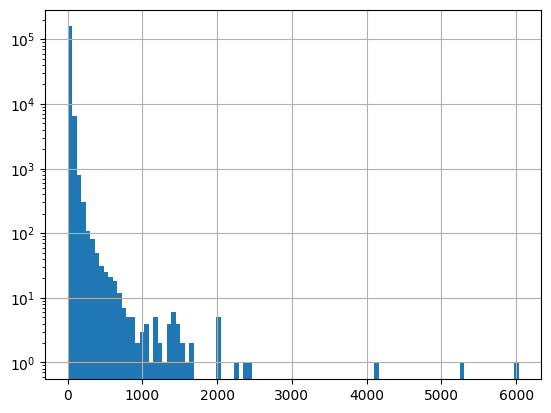

In [108]:
df['episode_run_time'].hist(bins=100, log=True)